# CSE547 - Colab 0
## Spark Tutorial

In this tutorial we will learn how to use [Apache Spark](https://spark.apache.org) in local mode on a Colab enviroment.

This is adapted from the Spark Tutorial used in the Applied Data Analysis class at EPFL taught by [Tiziano Piccardi](http://piccardi.me/), which was in turn adapted From Stanford's CS246.

### Setup

We'll begin by setting Spark on your Colab environment.  Run the cell below!

In [ ]:
!pip install pyspark
!pip install -U -q PyDrive
!apt update
!apt install openjdk-8-jdk-headless -qq
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=45a6015da535a9500b887b1b97362c51b4452793303e1d81c091e37e7fc6b1ca
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark
Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:4 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Hit:5 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [1,920 kB]
Get:7 http://archive.ubuntu.com/ubuntu jammy-updates/restricted amd64 Packages [2,104 kB]
Get:8 http://archive.ubuntu.com/ubuntu j

Now we authenticate a Google Drive client to download the file we will be processing in our Spark job. **Make sure to follow the interactive instructions, and allow Google Drive to save the data files.** Alternatively, download the files directly (see links below) and then upload them into your Colab instance

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
id='1yUNY2zq8NRn2LGsDurXqBwXv5XrqmIeH'
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('title.basics.tsv.gz')

id='1NY8-Hip68lS04FlaoZBTCSWf8wyKvK4h'
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('title.principals.tsv.gz')

We should now see the files *title.basics.tsv.gz* and *title.principals.tsv.gz* under the "Files" tab on the left panel.

In [ ]:
# Import the libraries we will need
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pyspark
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf

We first initialize the Spark context.


In [ ]:
# create the session
conf = SparkConf().set("spark.ui.port", "4050")

# create the context
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession.builder.getOrCreate()

We can easily check the current version and get the link of the web interface. In the Spark UI, we can monitor the progress of our job and debug performance bottlenecks (only when the Colab is running with a **local runtime**).

In [ ]:
spark

If, however, we choose to run this Colab on a Google hosted runtime, the cell below will create an *ngrok* tunnel which will allow us to check the Spark UI.

(Note: this cell is sometimes flaky.)

In [ ]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip
get_ipython().system_raw('./ngrok http 4050 &')
!curl http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url']);"

--2024-04-03 15:01:35--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 54.161.241.46, 54.237.133.81, 52.202.168.65, ...
Connecting to bin.equinox.io (bin.equinox.io)|54.161.241.46|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13921656 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  13.28M  6.06MB/s    in 2.2s    

2024-04-03 15:01:38 (6.06 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13921656/13921656]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    36  100    36    0     0  14331      0 --:--:-- --:--:-- --:--:-- 18000
Traceback (most recent call last):
  File "<string>", line 1, in <module>
IndexError: list index out of range

# IMDB

----


**The IMDB dataset describes TV, film, and other media titles listed on the IMDB site.**

This dataset consists of multiple tables, but we use only two for this lab. The below descriptions are copied from the IMDB dataset [interfaces page](https://www.imdb.com/interfaces/).

**Title Basic Information** [IMDB link](https://datasets.imdbws.com/title.basics.tsv.gz)
- tconst (string) - alphanumeric unique identifier of the title
- titleType (string) – the type/format of the title (e.g. movie, short, tvseries, tvepisode, video, etc)
- primaryTitle (string) – the more popular title / the title used by the filmmakers on promotional materials at the point of release
- originalTitle (string) - original title, in the original language
- isAdult (boolean) - 0: non-adult title; 1: adult title
- startYear (YYYY) – represents the release year of a title. In the case of TV Series, it is the series start year
- endYear (YYYY) – TV Series end year. ‘\N’ for all other title types
- runtimeMinutes – primary runtime of the title, in minutes
- genres (string array) – includes up to three genres associated with the title

**Principal Cast/Crew** [IMDB link](https://datasets.imdbws.com/title.principals.tsv.gz)
- tconst (string) - alphanumeric unique identifier of the title
- ordering (integer) – a number to uniquely identify rows for a given titleId
- nconst (string) - alphanumeric unique identifier of the name/person
- category (string) - the category of job that person was in
- job (string) - the specific job title if applicable, else '\N'
- characters (string) - the name of the character played if applicable, else '\N'



First, we load the datasets into Spark DataFrames:

In [ ]:
Titles = spark.read.csv("title.basics.tsv.gz", sep='\t', header=True)
Principals = spark.read.csv("title.principals.tsv.gz", sep='\t', header=True)

We can check the schema of each DataFrame:

In [ ]:
Titles.printSchema()

root
 |-- tconst: string (nullable = true)
 |-- titleType: string (nullable = true)
 |-- primaryTitle: string (nullable = true)
 |-- originalTitle: string (nullable = true)
 |-- isAdult: string (nullable = true)
 |-- startYear: string (nullable = true)
 |-- endYear: string (nullable = true)
 |-- runtimeMinutes: string (nullable = true)
 |-- genres: string (nullable = true)



In [ ]:
Principals.printSchema()

root
 |-- tconst: string (nullable = true)
 |-- ordering: string (nullable = true)
 |-- nconst: string (nullable = true)
 |-- category: string (nullable = true)
 |-- job: string (nullable = true)
 |-- characters: string (nullable = true)



`take()` returns a sample of rows:

In [ ]:
Titles.take(3)

[Row(tconst='tt0000001', titleType='short', primaryTitle='Carmencita', originalTitle='Carmencita', isAdult='0', startYear='1894', endYear='\\N', runtimeMinutes='1', genres='Documentary,Short'),
 Row(tconst='tt0000002', titleType='short', primaryTitle='Le clown et ses chiens', originalTitle='Le clown et ses chiens', isAdult='0', startYear='1892', endYear='\\N', runtimeMinutes='5', genres='Animation,Short'),
 Row(tconst='tt0000003', titleType='short', primaryTitle='Pauvre Pierrot', originalTitle='Pauvre Pierrot', isAdult='0', startYear='1892', endYear='\\N', runtimeMinutes='4', genres='Animation,Comedy,Romance')]

`show()` returns a *formatted* sample of rows:

In [ ]:
Principals.show()

+---------+--------+---------+---------------+--------------------+--------------+
|   tconst|ordering|   nconst|       category|                 job|    characters|
+---------+--------+---------+---------------+--------------------+--------------+
|tt0000001|       1|nm1588970|           self|                  \N|      ["Self"]|
|tt0000001|       2|nm0005690|       director|                  \N|            \N|
|tt0000001|       3|nm0374658|cinematographer|director of photo...|            \N|
|tt0000002|       1|nm0721526|       director|                  \N|            \N|
|tt0000002|       2|nm1335271|       composer|                  \N|            \N|
|tt0000003|       1|nm0721526|       director|                  \N|            \N|
|tt0000003|       2|nm1770680|       producer|            producer|            \N|
|tt0000003|       3|nm1335271|       composer|                  \N|            \N|
|tt0000003|       4|nm5442200|         editor|                  \N|            \N|
|tt0

In [ ]:
print(f"In total there are {Titles.count():,d} IMDB titles.")

In total there are 9,388,564 IMDB titles.


We'll do a little bit of preprocessing here to remove any titles with a null title type or start year field.

In [ ]:
Titles = Titles.replace({'\\N': None}).dropna(subset=['titleType', 'startYear'])

In [ ]:
print(f"After preprocessing, there are {Titles.count():,d} IMDB titles.")

After preprocessing, there are 8,127,526 IMDB titles.


## Question 1: How many titles of each type are in the IMDB dataset?

---



Keywords: `Dataframe API`, `SQL`, `group by`, `sort`

IMDB lists many different kinds of media -- movies, video games, TV episodes, etc. Let's group the IMDB titles by `titleType` and count how many records exist belonging to each title type:

In [ ]:
title_type_counts = Titles.groupBy("titleType")\
                                    .agg(count("*").alias("numTitles"))\
                                    .sort(desc("numTitles"))
title_type_counts.show()

+------------+---------+
|   titleType|numTitles|
+------------+---------+
|   tvEpisode|  5969375|
|       short|   873245|
|       movie|   542939|
|       video|   266050|
|    tvSeries|   216350|
|     tvMovie|   134634|
|tvMiniSeries|    43071|
|   tvSpecial|    38953|
|   videoGame|    32258|
|     tvShort|    10649|
|     tvPilot|        2|
+------------+---------+



In this case we use the Spark DataFrame API, but we could rewite this query using pure SQL:

In [ ]:
Titles.registerTempTable("Titles")

query = """
SELECT titleType, count(*) as numTitles
FROM Titles
GROUP BY titleType
ORDER BY numTitles DESC
"""

title_type_counts = spark.sql(query)
title_type_counts.show()

/usr/local/lib/python3.10/dist-packages/pyspark/sql/dataframe.py:329: FutureWarning: Deprecated in 2.0, use createOrReplaceTempView instead.
  warnings.warn("Deprecated in 2.0, use createOrReplaceTempView instead.", FutureWarning)


+------------+---------+
|   titleType|numTitles|
+------------+---------+
|   tvEpisode|  5969375|
|       short|   873245|
|       movie|   542939|
|       video|   266050|
|    tvSeries|   216350|
|     tvMovie|   134634|
|tvMiniSeries|    43071|
|   tvSpecial|    38953|
|   videoGame|    32258|
|     tvShort|    10649|
|     tvPilot|        2|
+------------+---------+



This Dataframe is small enough to be moved to Pandas, so we create a Pandas DataFrame object with all of the affordances of the Pandas API:

In [ ]:
title_type_count_pd = title_type_counts.toPandas()
title_type_count_pd.head()

,titleType,numTitles
0,tvEpisode,5969375
1,short,873245
2,movie,542939
3,video,266050
4,tvSeries,216350


We visualize this title type information by plotting a barchart with the number of titles by type:

Text(0.5, 1.0, 'Number of Titles by Type')

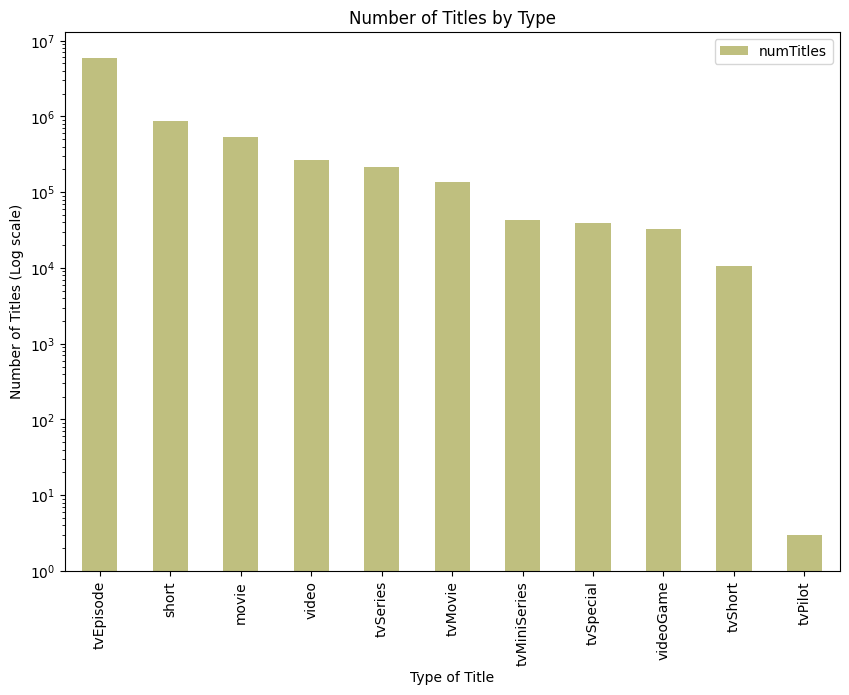

In [ ]:
pl = title_type_count_pd.plot(kind="bar",
                            x="titleType", y="numTitles",
                            figsize=(10, 7), log=True, alpha=0.5, color="olive")
pl.set_xlabel("Type of Title")
pl.set_ylabel("Number of Titles (Log scale)")
pl.set_title("Number of Titles by Type")

----

## Questions 2: Show the number of titles started in every year, by type of title (TV episode, short, movie, etc).

Keywords: `group by`, `parse date`, `plot`

We begin by selecting the relevant columns:

In [ ]:
year_titles = Titles.selectExpr(["titleType", "startYear"])
year_titles.printSchema()

root
 |-- titleType: string (nullable = true)
 |-- startYear: string (nullable = true)



Now we use the `.groupBy()` function from the Spark DataFrame API to get the number of titles with each  `titleType` and `startYear`:

In [ ]:
titles_by_year_and_type = year_titles\
                    .groupBy(["titleType", "startYear"])\
                    .agg(count("*").alias("numTitles"))\
                    .sort(asc("startYear")).toPandas()
titles_by_year_and_type.head()

,titleType,startYear,numTitles
0,short,1874,1
1,short,1877,4
2,short,1878,2
3,short,1881,2
4,short,1882,2


We plot this data using a different series for each type of IMDB title:

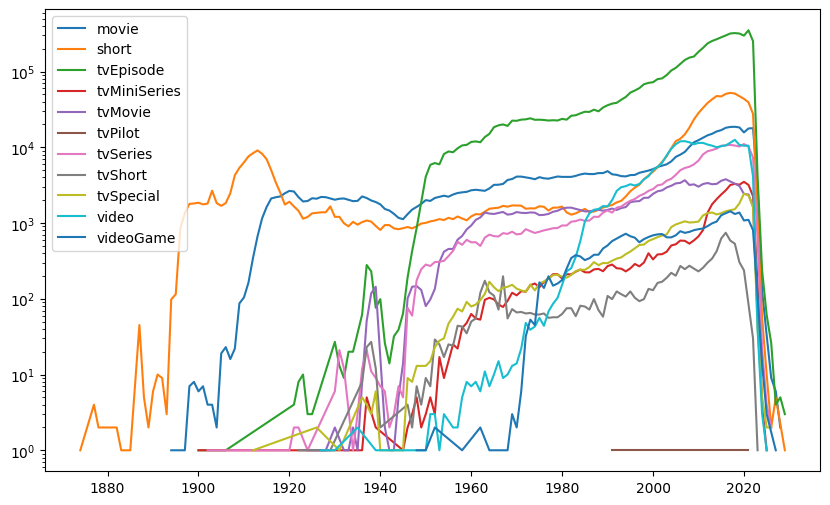

In [ ]:
fig = plt.figure(figsize=(10, 6))

# iterate the different groups to create a different series
for titleType, titles in titles_by_year_and_type.groupby("titleType"):
    plt.plot(
        pd.to_numeric(titles["startYear"]), titles["numTitles"], label=titleType
    )

plt.yscale('log')
plt.legend(loc='best')

We now observe that titles of the 'short' and 'movie' types increase in count in the 1890s and 1900s. Other title types, which all depend on distribution via household TVs, increase in count much later, around the 1940s-1950s. This intuitively coincides with TVs becoming more prevalent in households; in the US, household TV ownership rose from 9% to almost 90% during the 1950s.


----

## Question 3: What was the most popular genre of movie in 2000?

Keywords: `RDD map reduce` `cache` `save results`


We are interested in discovering what genre of movie was the most common  during the year of 2000.

We begin by filtering for movies that start in 2000:

In [ ]:
year2000_movies = Titles.where("titleType='movie' AND startYear='2000'")

We now split the genres column, which is currently formatted as a string, into an array of strings, then explode -- which means that we expand each row in the existing DataFrame by creating a copy of it for each distinct value in that array.

In [ ]:
year2000_movies = year2000_movies.select(["*", explode(split(Titles.genres, '[,]', 3)).alias("genre")])

In [ ]:
year2000_movies.show(20)

+---------+---------+--------------------+--------------------+-------+---------+-------+--------------+--------------------+---------+
|   tconst|titleType|        primaryTitle|       originalTitle|isAdult|startYear|endYear|runtimeMinutes|              genres|    genre|
+---------+---------+--------------------+--------------------+-------+---------+-------+--------------+--------------------+---------+
|tt0102362|    movie|              Istota|              Istota|      0|     2000|   NULL|            80|       Drama,Romance|    Drama|
|tt0102362|    movie|              Istota|              Istota|      0|     2000|   NULL|            80|       Drama,Romance|  Romance|
|tt0113026|    movie|     The Fantasticks|     The Fantasticks|      0|     2000|   NULL|            86|     Musical,Romance|  Musical|
|tt0113026|    movie|     The Fantasticks|     The Fantasticks|      0|     2000|   NULL|            86|     Musical,Romance|  Romance|
|tt0113086|    movie|Florentino y el d...|Floren

In [ ]:
year2000_movies.groupBy("genre").agg(count("*").alias("numTitles")).sort(desc("numTitles")).toPandas()

,genre,numTitles
0,Drama,1825
1,Documentary,1049
2,Comedy,980
3,Romance,515
4,Action,479
5,Thriller,393
6,Crime,384
7,Horror,232
8,Adventure,154
9,Family,139


'Drama' was the most common genre in IMDB movies of 2000, with 1825 movies being listed as dramas.

We can cache the content in memory, which saves time for repeat operations:

In [ ]:
year2000_movies.cache()

DataFrame[tconst: string, titleType: string, primaryTitle: string, originalTitle: string, isAdult: string, startYear: string, endYear: string, runtimeMinutes: string, genres: string, genre: string]

Now we count the number of rows and move the content to the cache:

In [ ]:
%time year2000_movies.count()

CPU times: user 222 ms, sys: 28.3 ms, total: 250 ms
Wall time: 33.7 s


7049

The second time we call `.count()`, the content has been cached and the operation is much faster:

In [ ]:
%time year2000_movies.count()

CPU times: user 2.02 ms, sys: 531 µs, total: 2.55 ms
Wall time: 181 ms


7049

We can also save the results in a file:

In [ ]:
year2000_movies.write.mode('overwrite').json("year2000_movies.json")

We can then read from that file into a Spark DataFrame again.

In [ ]:
year2000_movies = spark.read.json("year2000_movies.json")

As a reminder, we were previously using the Spark DataFrame API, as below:

In [ ]:
Counts = year2000_movies\
                .groupBy("genre").agg(count("*").alias("numTitles")).sort(desc("numTitles"))
Counts.show()

+-----------+---------+
|      genre|numTitles|
+-----------+---------+
|      Drama|     1825|
|Documentary|     1049|
|     Comedy|      980|
|    Romance|      515|
|     Action|      479|
|   Thriller|      393|
|      Crime|      384|
|     Horror|      232|
|  Adventure|      154|
|     Family|      139|
|    Mystery|      121|
|    Fantasy|      115|
|      Music|      109|
|  Biography|      107|
|  Animation|       84|
|     Sci-Fi|       80|
|    Musical|       69|
|    History|       68|
|        War|       59|
|      Sport|       48|
+-----------+---------+
only showing top 20 rows



But we can also do the same operations using the explicit Map-Reduce format with RDDs.

First we output, from each row, a tuple of data with format (genre, 1):

In [ ]:
all_genres = year2000_movies.rdd.map(lambda row: (row.genre, 1))
all_genres.take(3)

[('Drama', 1), ('Romance', 1), ('Musical', 1)]

Then, we sum the counters in the reduce step, and we sort the resulting data by count:

In [ ]:
genres_counts_rdd = all_genres.reduceByKey(lambda a, b: a+b)\
                                      .sortBy(lambda r: -r[1])
genres_counts_rdd.take(3)

[('Drama', 1825), ('Documentary', 1049), ('Comedy', 980)]

Now we can convert the RDD to a DataFrame by mapping the pairs to objects of type `Row`

In [ ]:
genres_counts_with_schema = genres_counts_rdd\
                      .map(lambda r: Row(genre=r[0], numTitles=r[1]))
genres_counts = spark.createDataFrame(genres_counts_with_schema)
genres_counts.show()

+-----------+---------+
|      genre|numTitles|
+-----------+---------+
|      Drama|     1825|
|Documentary|     1049|
|     Comedy|      980|
|    Romance|      515|
|     Action|      479|
|   Thriller|      393|
|      Crime|      384|
|     Horror|      232|
|  Adventure|      154|
|     Family|      139|
|    Mystery|      121|
|    Fantasy|      115|
|      Music|      109|
|  Biography|      107|
|  Animation|       84|
|     Sci-Fi|       80|
|    Musical|       69|
|    History|       68|
|        War|       59|
|      Sport|       48|
+-----------+---------+
only showing top 20 rows




As we see, the results with Map-Reduce match the results we had previously when conducting this query with the DataFrame API.


----

## Questions 4: What is the most common category of job for someone working on an IMDB title in 1980?

Keywords: `join` `group by`

We begin by inspecting the content of `Principals`, which contains the principal cast and crew on each IMDB title:

In [ ]:
Principals.show(5)

+---------+--------+---------+---------------+--------------------+----------+
|   tconst|ordering|   nconst|       category|                 job|characters|
+---------+--------+---------+---------------+--------------------+----------+
|tt0000001|       1|nm1588970|           self|                  \N|  ["Self"]|
|tt0000001|       2|nm0005690|       director|                  \N|        \N|
|tt0000001|       3|nm0374658|cinematographer|director of photo...|        \N|
|tt0000002|       1|nm0721526|       director|                  \N|        \N|
|tt0000002|       2|nm1335271|       composer|                  \N|        \N|
+---------+--------+---------+---------------+--------------------+----------+
only showing top 5 rows



We are interested in the field `category`, which lists the category of job occupied by the cast or crew member.

In [ ]:
Principals.select("category").show(5)

+---------------+
|       category|
+---------------+
|           self|
|       director|
|cinematographer|
|       director|
|       composer|
+---------------+
only showing top 5 rows



From the `Titles` dataframe, we first select all titles with `startYear` of 1980:

In [ ]:
year1980_titles = Titles.where("startYear='1980'")

We now join on the column `tconst` of both dataframes.

With the Spark Dataframe API:

In [ ]:
titles_joined = Principals.join(
                  year1980_titles, Principals.tconst == year1980_titles.tconst)
titles_joined.show(5)

+---------+--------+---------+--------+---+------------------+---------+---------+------------+-------------+-------+---------+-------+--------------+------+
|   tconst|ordering|   nconst|category|job|        characters|   tconst|titleType|primaryTitle|originalTitle|isAdult|startYear|endYear|runtimeMinutes|genres|
+---------+--------+---------+--------+---+------------------+---------+---------+------------+-------------+-------+---------+-------+--------------+------+
|tt0078994|      10|nm0677612|   actor| \N|        ["Felipe"]|tt0078994|    movie| El consenso|  El consenso|      0|     1980|   NULL|            89|Comedy|
|tt0078994|       1|nm0379883| actress| \N|          ["Pura"]|tt0078994|    movie| El consenso|  El consenso|      0|     1980|   NULL|            89|Comedy|
|tt0078994|       2|nm0513298| actress| \N|      ["Asunción"]|tt0078994|    movie| El consenso|  El consenso|      0|     1980|   NULL|            89|Comedy|
|tt0078994|       3|nm0580853|   actor| \N|       ["

We can select only the field we are interested in:

In [ ]:
title_job_categories = titles_joined.select("category")
title_job_categories.show(5)

+--------+
|category|
+--------+
|   actor|
| actress|
| actress|
|   actor|
| actress|
+--------+
only showing top 5 rows



And finally, we can group by `category` and then aggregate and count:

In [ ]:
title_job_categories.groupBy("category").agg(count("*").alias("numPrincipals"))\
                  .sort(desc("numPrincipals"))\
                  .show()

+-------------------+-------------+
|           category|numPrincipals|
+-------------------+-------------+
|              actor|        54902|
|            actress|        41531|
|               self|        32812|
|             writer|        32026|
|           director|        24850|
|           producer|        12458|
|           composer|         7826|
|    cinematographer|         6394|
|             editor|         5676|
|production_designer|         2985|
|    archive_footage|          741|
|      archive_sound|            2|
+-------------------+-------------+



Alternatively, we can rewrite this query in pure SQL:

In [ ]:
year1980_titles.registerTempTable("Year1980Titles")
Principals.registerTempTable("Principals")

query = """
SELECT category, count(*) numPrincipals
FROM Year1980Titles ti
JOIN Principals pr
ON ti.tconst = pr.tconst
GROUP BY category
ORDER BY numPrincipals DESC
"""

spark.sql(query).show()

/usr/local/lib/python3.10/dist-packages/pyspark/sql/dataframe.py:329: FutureWarning: Deprecated in 2.0, use createOrReplaceTempView instead.
  warnings.warn("Deprecated in 2.0, use createOrReplaceTempView instead.", FutureWarning)


+-------------------+-------------+
|           category|numPrincipals|
+-------------------+-------------+
|              actor|        54902|
|            actress|        41531|
|               self|        32812|
|             writer|        32026|
|           director|        24850|
|           producer|        12458|
|           composer|         7826|
|    cinematographer|         6394|
|             editor|         5676|
|production_designer|         2985|
|    archive_footage|          741|
|      archive_sound|            2|
+-------------------+-------------+



The job category of `actor` was most common in IMDB titles from 1980. The second most common job category was `actress`. Further data preprocessing might merge these two categories into a single non-gendered category.

In [ ]:
get_ipython().system_raw('./ngrok http 4050 &')